In [45]:
import mysql.connector
import sshtunnel
from mysql.connector import errorcode

def init_mysql():
    global cnx
    cnx = mysql.connector.connect(user='user1', password='tkfkdgody1!', host='52.79.185.101', database='Crawling')
    global cursor
    cursor = cnx.cursor()


In [46]:
add_foreground = ("INSERT IGNORE INTO foreground (title, press, link, day, class) "
                  "VALUES (%(title)s, %(press)s, %(link)s, %(day)s, %(class)s)")
add_background = ("INSERT IGNORE INTO background (tfidf,link) "
                 "VALUES (%(tfidf)s, %(link)s)")
clear_db = ("")

In [47]:
from time import sleep
import requests
from bs4 import BeautifulSoup, NavigableString

def get_html(url):
    _html = ""
    resp = requests.get(url)
    resp.encoding='utf-8'
    if resp.status_code == 200 :
        _html = resp.text
    return _html

In [48]:
#정치 경제 스포츠 연예 사회 국제
#politics economy sports enter national inter
#조선일보 경제는 biz.chosun.com...
CHOSUN = [("http://news.chosun.com/politics",'politics'),("http://news.chosun.com/sports",'sports'), ("http://news.chosun.com/ent",'enter'), ("http://news.chosun.com/national",'national'),( "http://news.chosun.com/international",'inter')]

#동아일보는 패턴 통일
DONGA = [("http://news.donga.com/Politics",'politics'),("http://news.donga.com/Economy",'economy'),("http://news.donga.com/Sports",'sports'),("http://news.donga.com/Enter",'enter'),("http://news.donga.com/Society",'national'),("http://news.donga.com/Inter",'inter')]

#중앙일보 연예가 가요, 방송, 영화로 나눠져있음
JOONGANG = [("http://news.joins.com/politics",'politics'),("http://news.joins.com/money",'economy'),("http://news.joins.com/sports",'sports'),("http://news.joins.com/society",'national'),("http://news.joins.com/world",'inter')]
JOONGANG_CUL = [("http://news.joins.com/culture/song/list",'enter'),("http://news.joins.com/culture/broadcast/list",'enter'),("http://news.joins.com/culture/movie/list",'enter')]

#기사 내용을 담을 변수

num_press = 3
num_class = 6
docs = [[] for i in range(num_class)]

    중앙일보 날짜 가져오기 힘들어서 datetime 패키지를 이용하여 임의로 날짜 입력

In [49]:
from datetime import datetime

In [50]:
def chosun_crawling():
    data_foreground = []
    i = 0
    for clas in CHOSUN:
        html = get_html(clas[0])
        print(clas[0])
        soup = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
        for lt in soup.find_all("dt") :
            try :
                tmp = lt.find('a')
                link = tmp.get('href')
                day = link.split('/')
                day = day[6]+day[7]+day[8]
                text = tmp.get_text()
                data_foreground.append({'title' : text, 'press' : 'chosun',  'link' : link, 'day' : day, 'class' : clas[1]})
                html = get_html(link)
                soup2 = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
                docs[i].append((soup2.find('div',attrs={'class' : 'par'}).get_text(),link))
            except : 
                print('error!!!',link)
        #docs[i].append(tmp_list)
        i = i + 1
        if i == 1 :
            i = i + 1
    cursor.executemany(add_foreground, data_foreground)
    cnx.commit()
    return

def chosun_biz():
    html = get_html('http://biz.chosun.com')
    print('http://biz.chosun.com')
    soup = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
    data_foreground = []
    head = soup.find("div", attrs={'class' : 'mt_art_tit'})
    tmp = head.find('a')
    link = tmp.get('href')
    day = link.split('/')
    day = day[6]+day[7]+day[8]
    text = tmp.get_text()
    data_foreground.append({'title' : text, 'press' : 'chosun',  'link' : link, 'day' : day, 'class' : 'economy'})
    
    html = get_html(link)
    soup2 = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
    docs[1].append((soup2.find('div',id = 'article_2011', attrs={'class':'article'}).get_text(),link))
    
    art = soup.find("div", attrs={'class' : 'mc_art_lst'})
    for lt in art.find_all("li", limit = 30) :
        try :
            tmp = lt.find('a')
            #print(tmp)
            link = tmp.get('href')
            day = link.split('/')
            day = day[6]+day[7]+day[8]
            text = tmp.get_text()
            data_foreground.append({'title' : text, 'press' : 'chosun',  'link' : link, 'day' : day,'class':'economy'})
            html = get_html(link)
            soup2 = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
            docs[1].append((soup2.find('div',id = 'article_2011', attrs={'class':'article'}).get_text(),link))
        except : 
            print('error!!!',link)
    cursor.executemany(add_foreground, data_foreground)
    cnx.commit()
    return 


In [51]:
def donga_crawling():
    data_foreground = []
    #docs = []
    i = 0
    for clas in DONGA:
        html = get_html(clas[0])
        print(clas[0])
        soup = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
        try:
            tmp = soup.find('div',attrs={'class':'articleTop'})
            head = tmp.find("div", attrs={'class' : 'articleMain'})
            #해드라인_main
            head_main = head.find('a')
            link = head_main.get('href')
            day = link.split('/')[6]
            text = head.find(attrs={'class' : 'title'}).get_text()
            data_foreground.append({'title' : text, 'press' : 'donga',  'link' : link, 'day' : day,'class':clas[1]})
            #print(data_foreground)
            html = get_html(link)
            soup2 = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
            docs[i].append((soup2.find('div',attrs={'class':'article_txt'}).get_text(),link))
            for head_sub in tmp.find_all('li') :
                art = head_sub.find('a')
                link = art.get('href')
                day = link.split('/')[6]
                text = art.find(attrs={'class':'title'}).get_text()
                data_foreground.append({'title' : text, 'press' : 'donga',  'link' : link, 'day' : day,'class':clas[1]})
                html = get_html(link)
                soup2 = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
                docs[i].append((soup2.find('div',attrs={'class':'article_txt'}).get_text(),link))

        except :
            for head in tmp.find_all('div',attrs={'class':'artivleMain'}):
                art = head.find('a')
                link = art.get('href')
                day = link.split('/')[6]
                text = art.find(attrs={'class':'title'}).get_text()
                data_foreground.append({'title' : text, 'press' : 'donga',  'link' : link, 'day' : day,'class':clas[1]})
                html = get_html(link)
                soup2 = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
                docs[i].append((soup2.find('div',attrs={'class':'article_txt'}).get_text(),link))

                
            for head in tmp.find_all('div',attrs={'class':'artivleMain02'}):
                art = head.find('a')
                link = art.get('href')
                day = link.split('/')[6]
                text = art.find(attrs={'class':'title'}).get_text()
                data_foreground.append({'title' : text, 'press' : 'donga',  'link' : link, 'day' : day,'class':clas[1]})
                html = get_html(link)
                soup2 = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
                docs[i].append((soup2.find('div',attrs={'class':'article_txt'}).get_text(),link))

        try:
            #issue
            content_issue = soup.find('div',attrs={'class':'issueList'})
            issue = content_issue.find('a', attrs={'class' : 'tit'})
            link = issue.get('href')
            day = link.split('/')[6]
            text = issue.get_text();
            data_foreground.append({'title' : text, 'press' : 'donga',  'link' : link, 'day' : day,'class':clas[1]})
            html = get_html(link)
            soup2 = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
            docs[i].append((soup2.find('div',attrs={'class':'atrticle_txt'}).get_text(),link))
            for issue_sub in content_issue.find_all('li') :
                art = issue_sub.find('a')
                link = art.get('href')
                day = link.split('/')[6]
                text = art.get_text()
                data_foreground.append({'title' : text, 'press' : 'donga',  'link' : link, 'day' : day,'class':clas[1]})
                html = get_html(link)
                soup2 = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
                docs[i].append((soup2.find('div',attrs={'class':'article_txt'}).get_text(),link))
        except :
            print('error!!!',link)
            
        try:
            #최신기사
            contents = soup.find('div',attrs={'class':'articleList_con'})
            for art in contents.find_all('div',attrs={'class':'rightList'}) :
                tmp = art.find('a')
                link = tmp.get('href')
                day = link.split('/')[6]
                text = tmp.find(attrs={'class':'tit'}).get_text()
                data_foreground.append({'title' : text, 'press' : 'donga',  'link' : link, 'day' : day,'class':clas[1]})
                html = get_html(link)
                soup2 = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
                docs[i].append((soup2.find('div',attrs={'class':'article_txt'}).get_text(),link))
        except :
            print('error!!!',link)
        i = i + 1
    cursor.executemany(add_foreground, data_foreground)
    cnx.commit()
    return 

In [52]:
def joongang_crawling():
    day = datetime.today().strftime("%Y%m%d")
    data_foreground = []
    i = 0
    for clas in JOONGANG:
        html = get_html(clas[0])
        print(clas[0])
        soup = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
        origin = soup.find('div',id='content')
        #해드라인
        try:
            art = origin.find('dt')
            tmp = art.find('a')
            link = tmp.get('href')
            text = tmp.get_text()
            data_foreground.append({'title' : text, 'press' : 'joongang',  'link' : link, 'day' : day,'class':clas[1]})
            html2 = get_html(link)
            soup2 = BeautifulSoup(html2, 'lxml', from_encoding='utf-8')
            docs[i].append((soup2.find('div', attrs={'class':'article_body'}, id = 'article_body').get_text(),link))
        except :
            #sport 해드라인
            try:
                for art in origin.find_all('div',attrs={'class':'slide'}):
                    tmp = art.find(attrs={'class':'headline mg'})
                    tmp2 = tmp.find('a')
                    link = tmp2.get('href')
                    text = tmp2.get_text();
                    data_foreground.append({'title' : text, 'press' : 'joongang',  'link' : link, 'day' : day,'class':clas[1]})
                    html2 = get_html(link)
                    soup2 = BeautifulSoup(html2, 'lxml', from_encoding='utf-8')
                    docs[i].append((soup2.find('div', attrs={'class':'article_body'}, id = 'article_body').get_text(),link))
            except:
                print('error!!!',link)
        
        #실시간 주요뉴스
        try:
            art = origin.find('div',attrs={'class':'default_realtime'})
            art = art.find('ul',id='ulItems')
            #print(art)
            for content in art.find_all('li'):
                #print(content)
                tmp = content.find(attrs={'class':'headline mg'})
                tmp2 = tmp.find('a')
                link = 'http://news.joins.com/' + tmp2.get('href')
                text = tmp2.get_text()
                data_foreground.append({'title' : text, 'press' : 'joongang',  'link' : link, 'day' : day,'class':clas[1]})
                html2 = get_html(link)
                soup2 = BeautifulSoup(html2, 'lxml', from_encoding='utf-8')
                docs[i].append((soup2.find('div', attrs={'class':'article_body'}, id = 'article_body').get_text(),link))
        except:
            try:
                art = origin.find('div',attrs={'class':'combination_today'})
                art = art.find('div',attrs={'class':'bd'})
                for content in art.find_all('li'):
                    tmp = content.find(attrs={'class':'headline mg'})
                    tmp2 = tmp.find('a')
                    link = 'http://news.joins.com/' + tmp2.get('href')
                    text = tmp2.get_text()
                    data_foreground.append({'title' : text, 'press' : 'joongang',  'link' : link, 'day' : day,'class':clas[1]})
                    html2 = get_html(link)
                    soup2 = BeautifulSoup(html2, 'lxml', from_encoding='utf-8')
                    docs[i].append((soup2.find('div', attrs={'class':'article_body'}, id = 'article_body').get_text(),link))
            except :
                print('error!!!',link)
        i = i + 1
        if i == 3 :
            i = i + 1
    cursor.executemany(add_foreground, data_foreground)
    cnx.commit()
    return 

def joongang_cul():
    day = datetime.today().strftime("%Y%m%d")
    dosc = []
    #tmp_list = []
    data_foreground = []
    for clas in JOONGANG_CUL:
        html = get_html(clas[0])
        print(clas[0])
        soup = BeautifulSoup(html, 'lxml', from_encoding='utf-8')
        
        origin = soup.find('div',id='content')
        for content in origin.find_all('li'):
            art = content.find(attrs={'class':'headline mg'})
            tmp = art.find('a')
            link = 'http://news.joins.com' + tmp.get('href')
            text = tmp.get_text()
            data_foreground.append({'title' : text, 'press' : 'joongang',  'link' : link, 'day' : day,'class':clas[1]})
            html2 = get_html(link)
            soup2 = BeautifulSoup(html2, 'lxml', from_encoding='utf-8')
            docs[3].append((soup2.find('div', attrs={'class':'article_body'}, id = 'article_body').get_text(),link))
    cursor.executemany(add_foreground, data_foreground)
    cnx.commit()
    return 



    scikit-Learn 패키지를 이용한 TF-IDF 계산


In [589]:
import nltk,  operator, re
import pandas as pd
import numpy as np
from konlpy.tag import Twitter, Kkma
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

stopwords = ['.',',','\n','\xa0',re.compile('^A-Za-z*$')]


def cal_weight():
    tfidf_list = []
    tfidf_list_raw = []
    t = Twitter()
    k = Kkma()
    for i in range(num_class):
    #for i in range(1):
        nouns = []
        for article in docs[i]:
            if article[0] is not '':
                nouns.append(' '.join([noun for noun in t.nouns(str(article[0]))]))        
        vec = TfidfVectorizer(stop_words = stopwords)
        fitted = vec.fit(nouns)
        tfidf_res = fitted.transform(nouns)
        vocab = fitted.get_feature_names()
        j = 0
        for article in tfidf_res.toarray():
            idf = sorted(zip(vocab,article), key=lambda kv:kv[1])[-3:]
            tmp = idf[0][0]+' '+idf[1][0] + ' ' + idf[2][0]
            tfidf_list.append({'tfidf':tmp,'link':docs[i][j][1]})
            j = j + 1
    cursor.executemany(add_background, tfidf_list)
    cnx.commit()
    cursor.execute('delete from foreground where link not in (select link from background);')
    cnx.commit()
    print('cal_weight done!')
    return tfidf_list_raw

In [590]:
init_mysql()

In [513]:
destroy()

In [620]:
# bidirectional 모델 만들기!
from keras.layers import *
from keras.models import *
from keras.utils import *
from sklearn.preprocessing import *


#activate = 'tanh'
#kernel_init = 'glorot_uniform'
#time_step,  output_shape, model_name_to_save
def build_model(max_pad, categori_shape):
    activate = 'relu'
    kernel_init = 'Orthogonal'
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(max_pad,8), activation=activate, kernel_initializer = kernel_init))
    model.add(Dropout(0.2))
    model.add(LSTM(256, return_sequences=True, activation=activate, kernel_initializer = kernel_init))
    model.add(Dropout(0.2))
    model.add(Dense(categori_shape, activation='relu', kernel_initializer = 'Orthogonal'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    
    return model


In [621]:
def build_model_sigmoid(max_pad, categori_shape):
    activate_1 = 'sigmoid'
    kernel_init = 'glorot_uniform'
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(max_pad,8), activation=activate_1, kernel_initializer = kernel_init))
    model.add(Dropout(0.2))
    model.add(LSTM(256, return_sequences=True, activation=activate_1, kernel_initializer = kernel_init))
    model.add(Dropout(0.2))
    model.add(Dense(categori_shape, activation=activate_1, kernel_initializer = kernel_init))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    return model

In [622]:
def build_model_bi(max_pad, categori_shape):
    activate = 'relu'
    kernel_init = 'Orthogonal'
    model = Sequential()
    model.add(Bidirectional(LSTM(256, return_sequences=True, input_shape=(max_pad,8), activation=activate, kernel_initializer = kernel_init)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True, activation=activate, kernel_initializer = kernel_init)))
    model.add(Dropout(0.2))
    model.add(Dense(categori_shape, activation='relu', kernel_initializer = 'Orthogonal'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    
    return model

In [623]:
def build_model_sigmoid_bi(max_pad, categori_shape):
    activate_1 = 'sigmoid'
    kernel_init = 'glorot_uniform'
    model = Sequential()
    model.add(Bidirectional(LSTM(256, return_sequences=True, input_shape=(max_pad,8), activation=activate_1, kernel_initializer = kernel_init)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True, activation=activate_1, kernel_initializer = kernel_init)))
    model.add(Dropout(0.2))
    model.add(Dense(categori_shape, activation=activate_1, kernel_initializer = kernel_init))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    return model

In [617]:
def learning(model, train_X, train_Y, test_X, test_Y, model_name):
    history = model.fit(train_X,train_Y, epochs=150, batch_size=1, validation_split=0.1)
    score = model.evaluate(test_X, test_Y)
    model.save(datetime.today().strftime("%Y%m%d")+model_name)
    return (history, score)

In [618]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
def plt_init():
    plt.style.use('bmh')

#plot 그리기
def draw_plot(history, score, name):
    plt.figure(figsize=(6,6))
    plt.title(name)
    plt.plot(history.history['loss'], label = name)
    plt.plot(history.history['val_loss'], label = 'val_'+name)
    plt.legend()
    plt.show()
    fig = plt.gcf()
    fig.savefig(datetime.today().strftime("%Y%m%d")+'_'+name, bbox_inches='tight')
    print("loss over test data : %.2f" % (score[0]))
    print("accuracy over test data : %.2f" % (score[1]))

(6, 15, 8)
(6, 15, 168)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 15, 256)           271360    
_________________________________________________________________
dropout_131 (Dropout)        (None, 15, 256)           0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 15, 256)           525312    
_________________________________________________________________
dropout_132 (Dropout)        (None, 15, 256)           0         
_________________________________________________________________
dense_67 (Dense)             (None, 15, 168)           43176     
Total params: 839,848
Trainable params: 839,848
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape     

3/3 [==============================] - 1s 176ms/step - loss: 0.3181 - acc: 0.9824 - val_loss: 0.3393 - val_acc: 0.9825
Epoch 48/150
3/3 [==============================] - 0s 153ms/step - loss: 0.3378 - acc: 0.9806 - val_loss: 0.3392 - val_acc: 0.9825
Epoch 49/150
3/3 [==============================] - 0s 154ms/step - loss: 0.3576 - acc: 0.9788 - val_loss: 0.3391 - val_acc: 0.9825
Epoch 50/150
3/3 [==============================] - 0s 153ms/step - loss: 0.3309 - acc: 0.9808 - val_loss: 0.3389 - val_acc: 0.9825
Epoch 51/150
3/3 [==============================] - 0s 158ms/step - loss: 0.3074 - acc: 0.9837 - val_loss: 0.3331 - val_acc: 0.9829
Epoch 52/150
3/3 [==============================] - 0s 148ms/step - loss: 0.3032 - acc: 0.9843 - val_loss: 0.3325 - val_acc: 0.9833
Epoch 53/150
3/3 [==============================] - 0s 160ms/step - loss: 0.2984 - acc: 0.9848 - val_loss: 0.3322 - val_acc: 0.9833
Epoch 54/150
3/3 [==============================] - 1s 171ms/step - loss: 0.2981 - acc: 0

3/3 [==============================] - 0s 157ms/step - loss: 0.2785 - acc: 0.9861 - val_loss: 0.2878 - val_acc: 0.9861
Epoch 110/150
3/3 [==============================] - 0s 159ms/step - loss: 0.2785 - acc: 0.9861 - val_loss: 0.2878 - val_acc: 0.9861
Epoch 111/150
3/3 [==============================] - 0s 159ms/step - loss: 0.2786 - acc: 0.9860 - val_loss: 0.2878 - val_acc: 0.9861
Epoch 112/150
3/3 [==============================] - 0s 166ms/step - loss: 0.2769 - acc: 0.9861 - val_loss: 0.2878 - val_acc: 0.9861
Epoch 113/150
3/3 [==============================] - 1s 170ms/step - loss: 0.2789 - acc: 0.9860 - val_loss: 0.2878 - val_acc: 0.9861
Epoch 114/150
3/3 [==============================] - 1s 169ms/step - loss: 0.2785 - acc: 0.9861 - val_loss: 0.2878 - val_acc: 0.9861
Epoch 115/150
3/3 [==============================] - 0s 156ms/step - loss: 0.2787 - acc: 0.9861 - val_loss: 0.2878 - val_acc: 0.9861
Epoch 116/150
3/3 [==============================] - 0s 164ms/step - loss: 0.2785 -

3/3 [==============================] - 0s 148ms/step - loss: 0.0615 - acc: 0.9821 - val_loss: 0.0798 - val_acc: 0.9821
Epoch 21/150
3/3 [==============================] - 1s 167ms/step - loss: 0.0598 - acc: 0.9821 - val_loss: 0.0797 - val_acc: 0.9821
Epoch 22/150
3/3 [==============================] - 0s 163ms/step - loss: 0.0584 - acc: 0.9821 - val_loss: 0.0794 - val_acc: 0.9821
Epoch 23/150
3/3 [==============================] - 0s 159ms/step - loss: 0.0588 - acc: 0.9821 - val_loss: 0.0790 - val_acc: 0.9821
Epoch 24/150
3/3 [==============================] - 0s 159ms/step - loss: 0.0573 - acc: 0.9821 - val_loss: 0.0787 - val_acc: 0.9821
Epoch 25/150
3/3 [==============================] - 0s 159ms/step - loss: 0.0566 - acc: 0.9821 - val_loss: 0.0781 - val_acc: 0.9821
Epoch 26/150
3/3 [==============================] - 1s 173ms/step - loss: 0.0538 - acc: 0.9821 - val_loss: 0.0776 - val_acc: 0.9821
Epoch 27/150
3/3 [==============================] - 0s 163ms/step - loss: 0.0516 - acc: 0

Epoch 82/150
3/3 [==============================] - 0s 162ms/step - loss: -0.0067 - acc: 0.9860 - val_loss: 0.0410 - val_acc: 0.9861
Epoch 83/150
3/3 [==============================] - 0s 156ms/step - loss: -0.0055 - acc: 0.9860 - val_loss: 0.0411 - val_acc: 0.9861
Epoch 84/150
3/3 [==============================] - 0s 165ms/step - loss: -0.0060 - acc: 0.9860 - val_loss: 0.0412 - val_acc: 0.9861
Epoch 85/150
3/3 [==============================] - 0s 157ms/step - loss: -0.0069 - acc: 0.9858 - val_loss: 0.0415 - val_acc: 0.9861
Epoch 86/150
3/3 [==============================] - 0s 162ms/step - loss: -0.0060 - acc: 0.9858 - val_loss: 0.0415 - val_acc: 0.9861
Epoch 87/150
3/3 [==============================] - 1s 172ms/step - loss: -0.0071 - acc: 0.9858 - val_loss: 0.0417 - val_acc: 0.9861
Epoch 88/150
3/3 [==============================] - 0s 162ms/step - loss: -0.0064 - acc: 0.9858 - val_loss: 0.0419 - val_acc: 0.9861
Epoch 89/150
3/3 [==============================] - 0s 163ms/step - l

3/3 [==============================] - 0s 152ms/step - loss: -0.0110 - acc: 0.9861 - val_loss: 0.0483 - val_acc: 0.9861
Epoch 144/150
3/3 [==============================] - 0s 165ms/step - loss: -0.0107 - acc: 0.9861 - val_loss: 0.0484 - val_acc: 0.9861
Epoch 145/150
3/3 [==============================] - 0s 158ms/step - loss: -0.0101 - acc: 0.9860 - val_loss: 0.0484 - val_acc: 0.9861
Epoch 146/150
3/3 [==============================] - 1s 171ms/step - loss: -0.0108 - acc: 0.9861 - val_loss: 0.0485 - val_acc: 0.9861
Epoch 147/150
3/3 [==============================] - 0s 166ms/step - loss: -0.0115 - acc: 0.9861 - val_loss: 0.0486 - val_acc: 0.9861
Epoch 148/150
3/3 [==============================] - 0s 162ms/step - loss: -0.0110 - acc: 0.9860 - val_loss: 0.0488 - val_acc: 0.9861
Epoch 149/150
3/3 [==============================] - 0s 161ms/step - loss: -0.0103 - acc: 0.9861 - val_loss: 0.0489 - val_acc: 0.9861
Epoch 150/150
2/2 [==============================] - 0s 47ms/step


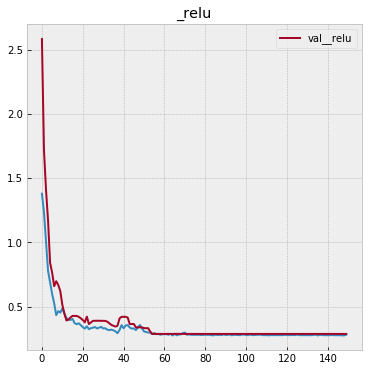

loss over test data : 0.29
accuracy over test data : 0.99


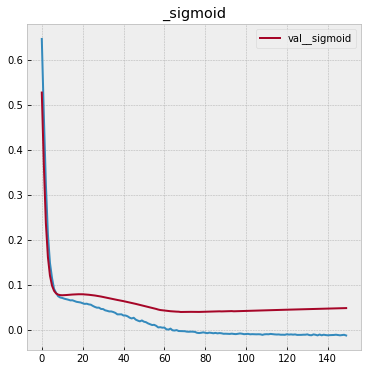

loss over test data : 0.04
accuracy over test data : 0.99


In [619]:
def recommand():
    
    max_pad = 15
    
    global cursor
    
    #db에서 데이터 불러오기
    cursor.execute('select * from user_tfidf')
    user_tfidf_info = cursor.fetchall()
    cursor.execute('select * from user_pri')
    user_pri_info = cursor.fetchall()
    
    #tokenizer 
    token = Tokenizer()
    
    #db에서 불러온 데이터 dataframe형태로 저장
    user_tfidf = pd.DataFrame(user_tfidf_info,columns = ['ID','tfidf'])
    user_pri = pd.DataFrame(user_pri_info,columns = ['ID','age','gender','inter1','inter2','inter3'])
    
    #tfidf 분할을 위해 따로 drop
    user_tfidf_value = user_tfidf.drop(columns = ['ID']).values
    user_tfidf = user_tfidf.drop(['tfidf'],axis=1)
    
    i = 0
    tmp = []
    #tfidf 분할
    for arg in user_tfidf_value:
        tmp.append(' '.join(arg).split(' '))
    
    #tokenizer 학습
    token.fit_on_texts(tmp)
    
    tmp = token.texts_to_sequences(tmp)
    
    #분할 한 tfidf dataframe으로 만든 후 원본과 합친다
    tmp = pd.DataFrame(tmp,columns = ['tfidf','tfidf2','tfidf3'])
    
    user_tfidf = pd.concat([user_tfidf,tmp],axis=1)
    
    #tfidf와 사용자 정보를 merge
    merged = pd.merge(user_tfidf,user_pri)
    
    #ID별로 Y 구하기 위해 추출
    ID = user_tfidf.ID.unique()
    
    train_X = []
    train_Y = []
    #train_X max_pad 만큼 ID별로 데이터 추가하거나 삭제
    for id in ID:
        tmp = merged.loc[merged['ID'] == id,'tfidf':].values.T
        tmp = pad_sequences(tmp,maxlen = max_pad).T
        train_X.extend(tmp)
    
    train_X = np.array(train_X)[:,np.newaxis].reshape(-1,max_pad,8)
    
    #train_X.reshape(-1,8,1)
    #print(train_X.shape)
    
    #ID별로 train_Y
    
    for id in ID:
        user_private = merged.loc[merged['ID'] == id, 'tfidf' : 'tfidf3' ].values
        user_private = np.vstack((user_private[1:],user_private[0])).T
        user_private = pad_sequences(user_private, maxlen = max_pad).T
        train_Y.extend(user_private)
    
    tmp = []
    for target in to_categorical(np.array(train_Y).reshape(-1,3)):
        tmp.append(sum(target))
    
    train_Y = np.array(tmp)[:,np.newaxis].reshape(-1,max_pad,len(tmp[0]))
    #print(train_Y.shape)
    
    split = int(len(train_X)*0.8)
    #모델 구축
    model = build_model(max_pad, train_Y.shape[2])
    model_sig = build_model_sigmoid(max_pad, train_Y.shape[2])
    model_bi = build_model_bi(max_pad, train_Y.shape[2])
    model_sig_bi = build_model_sigmoid_bi(max_pad, train_Y.shape[2])
    
    #모델 run
    (history, score) = learning(model, train_X[:split],train_Y[:split],train_X[split:],train_Y[split:],'_relu')
    (history2, score2) = learning(model_sig, train_X[:split],train_Y[:split],train_X[split:],train_Y[split:],'_sigmoid')
    (history3, score3) = learning(model_sig, train_X[:split],train_Y[:split],train_X[split:],train_Y[split:],'_relu_bi')
    (history4, score4) = learning(model_sig, train_X[:split],train_Y[:split],train_X[split:],train_Y[split:],'_sigmoid_bi')
    #plot iniit
    plt = plt_init()
    
    #plot 그리기
    draw_plot(history, score, '_relu')
    draw_plot(history2, score2,'_sigmoid')
    draw_plot(history3, score3,'_relu_bi')
    draw_plot(history4, score4,'_sigmoid_bi')
    
recommand()

In [56]:
def destroy():
    cursor.close()
    cnx.close()

In [57]:
def main():
    
    init_mysql()
    
    joongang_crawling()
    joongang_cul()
    chosun_crawling()
    chosun_biz()
    donga_crawling()
    
    ret = cal_weight()
    
    #destroy()
    
    return ret

In [58]:
import time

if __name__ == '__main__':
    startTime = time.time()
    tfidf_raw = main()
    endTime = time.time()
    print(endTime - startTime)
    

http://news.joins.com/politics


C:\Anaconda\lib\site-packages\bs4\__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


http://news.joins.com/money
http://news.joins.com/sports
http://news.joins.com/society
error!!! http://news.joins.com//article/23047215
http://news.joins.com/world
http://news.joins.com/culture/song/list
http://news.joins.com/culture/broadcast/list
http://news.joins.com/culture/movie/list
http://news.chosun.com/politics
error!!! http://forum.chosun.com/message/messageView.forum?bbs_id=1010&message_id=1382936
error!!! http://forum.chosun.com/message/messageView.forum?bbs_id=1010&message_id=1382930
http://news.chosun.com/sports
http://news.chosun.com/ent
http://news.chosun.com/national
error!!! http://news.chosun.com/site/data/html_dir/2018/10/16/2018101600401.html
error!!! http://news.chosun.com/site/data/html_dir/2018/10/16/2018101600401.html
error!!! http://news.chosun.com/site/data/html_dir/2018/10/16/2018101600401.html
error!!! http://news.chosun.com/site/data/html_dir/2018/10/16/2018101600401.html
error!!! http://forum.chosun.com/message/messageView.forum?bbs_id=1040&message_id=138

C:\Anaconda\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


cal_weight done!
215.955726146698
